In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def get_high_low_loaders(data_set):
  train_idx_h = [h for h in range(len(data_set.targets)) if data_set.targets[h] == 0]
  train_idx_l = [l for l in range(len(data_set.targets)) if data_set.targets[l] == 1]

  # high resolution
  train_set_h = torch.utils.data.Subset(data_set, train_idx_h)
  train_loader_h = torch.utils.data.DataLoader(dataset=train_set_h, batch_size=batch_size, shuffle=False)

  # low resolution
  train_set_l = torch.utils.data.Subset(data_set, train_idx_l)
  train_loader_l = torch.utils.data.DataLoader(dataset=train_set_l, batch_size=batch_size, shuffle=False)

  return train_loader_h, train_loader_l


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32

img_transform = transform.Compose([transform.ToTensor()]) 

# Training Set
train_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/Public/images/train', img_transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(train_set)

# Testing Set
test_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/Public/images/val', img_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(test_set)

cuda:0
Dataset ImageFolder
    Number of datapoints: 1370
    Root location: /content/drive/MyDrive/Public/images/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 340
    Root location: /content/drive/MyDrive/Public/images/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
init_dim = 256
encoder_conv1 = utils.size_output_layer(init_dim, 3, 1, 1)
print("encoder_conv1:", encoder_conv1)

encoder_conv2 = utils.size_output_layer(encoder_conv1, 3, 1, 1)
print("encoder_conv2:", encoder_conv2)

print("maxpooling:", utils.size_output_layer(encoder_conv2, 2, 2, 0))

encoder_conv3 = utils.size_output_layer(encoder_conv2, 4, 2, 1)
print("encoder_conv3:", encoder_conv3)

encoder_conv4 = utils.size_output_layer(encoder_conv3, 3, 1, 1)
print("encoder_conv4:", encoder_conv4)


encoder_conv1: 256
encoder_conv2: 256
maxpooling: 128
encoder_conv3: 128
encoder_conv4: 128


In [6]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
  
    self.conv4 = nn.Sequential(
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
        nn.Linear(in_features=1024*16*16, out_features=12)
    )

  def forward(self, image):
    self.out1 = self.conv1(image)
    self.out2 = self.conv2(self.out1)
    self.out3 = self.conv3(self.out2)
    self.out4 = self.conv4(self.out3)
    self.out5 = self.out4.view(self.out4.size(0), -1)
    z = self.fc(self.out5)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(in_features=12,out_features=1024*16*16)
    )

    self.convTran1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*1024, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )

    self.convTran2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*512, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )

    self.convTran3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*256, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )
  
    self.convTran4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*128, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )

    self.convTran5 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
   
  def forward(self, latent, encoder):
    out = self.fc(latent)
    out = out.view(out.size(0), 1024, 16, 16)
    out = self.convTran1(torch.cat([encoder.out4, out], dim=1))
    out = self.convTran2(torch.cat([encoder.out3, out], dim=1))
    out = self.convTran3(torch.cat([encoder.out2, out], dim=1))
    out = self.convTran4(torch.cat([encoder.out1, out], dim=1))
    out = torch.tanh(self.convTran5(out))
    return out


In [7]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent, self.encoder)
        return  x_recon

In [8]:
def train(model, images_set, Epochs, loss_fn):

    images_high_loader, images_low_loader = get_high_low_loaders(images_set)

    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0

      images_high_it = iter(images_high_loader)
    
      for image_batch, _ in tqdm(images_low_loader):
          image_batch = image_batch.to(device)
          
          image_batch_recon = model(image_batch)

          image_batch_high, _ = next(images_high_it)
          image_batch_high = image_batch_high.to(device)
          
          loss = loss_fn(image_batch_recon, image_batch_high)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

In [9]:
autoencoder = Autoencoder()
autoencoder.to(device)

print(autoencoder)

learning_rate = 0.001
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

Autoencoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0)

Autoencoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0)

In [10]:
loss_result = train(autoencoder, train_set, 20, loss)

100%|██████████| 22/22 [02:01<00:00,  5.54s/it]


Epoch [1 / 20] average reconstruction error: 0.136407


100%|██████████| 22/22 [01:58<00:00,  5.40s/it]


Epoch [2 / 20] average reconstruction error: 0.025712


100%|██████████| 22/22 [01:58<00:00,  5.40s/it]


Epoch [3 / 20] average reconstruction error: 0.012106


100%|██████████| 22/22 [01:58<00:00,  5.41s/it]


Epoch [4 / 20] average reconstruction error: 0.008041


100%|██████████| 22/22 [01:58<00:00,  5.40s/it]


Epoch [5 / 20] average reconstruction error: 0.004779


100%|██████████| 22/22 [01:58<00:00,  5.40s/it]


Epoch [6 / 20] average reconstruction error: 0.003362


100%|██████████| 22/22 [01:59<00:00,  5.41s/it]


Epoch [7 / 20] average reconstruction error: 0.002549


100%|██████████| 22/22 [01:59<00:00,  5.41s/it]


Epoch [8 / 20] average reconstruction error: 0.002616


100%|██████████| 22/22 [01:58<00:00,  5.40s/it]


Epoch [9 / 20] average reconstruction error: 0.002426


100%|██████████| 22/22 [01:58<00:00,  5.41s/it]


Epoch [10 / 20] average reconstruction error: 0.001952


100%|██████████| 22/22 [01:58<00:00,  5.38s/it]


Epoch [11 / 20] average reconstruction error: 0.001789


100%|██████████| 22/22 [01:58<00:00,  5.38s/it]


Epoch [12 / 20] average reconstruction error: 0.001765


100%|██████████| 22/22 [01:58<00:00,  5.38s/it]


Epoch [13 / 20] average reconstruction error: 0.001641


100%|██████████| 22/22 [01:58<00:00,  5.38s/it]


Epoch [14 / 20] average reconstruction error: 0.001571


100%|██████████| 22/22 [01:58<00:00,  5.38s/it]


Epoch [15 / 20] average reconstruction error: 0.001565


100%|██████████| 22/22 [01:58<00:00,  5.37s/it]


Epoch [16 / 20] average reconstruction error: 0.001487


100%|██████████| 22/22 [01:58<00:00,  5.36s/it]


Epoch [17 / 20] average reconstruction error: 0.001463


100%|██████████| 22/22 [01:58<00:00,  5.36s/it]


Epoch [18 / 20] average reconstruction error: 0.001434


100%|██████████| 22/22 [01:57<00:00,  5.36s/it]


Epoch [19 / 20] average reconstruction error: 0.001399


100%|██████████| 22/22 [01:57<00:00,  5.36s/it]

Epoch [20 / 20] average reconstruction error: 0.001382


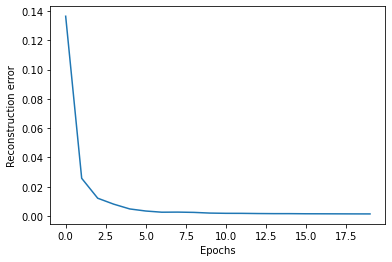

In [11]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [12]:
test_high_loader, test_low_loader = get_high_low_loaders(test_set)

autoencoder.eval()

with torch.no_grad():
  image, label = iter(test_low_loader).next()

  image = image.to(device)
  label = label.to(device)

  z = autoencoder.encoder(image)
  z = z.to(device)

  decodificado = autoencoder.decoder(z, autoencoder.encoder)
  decodificado = decodificado.to('cpu')

In [13]:
def plot_image(images_l, images_h, decodificado, idx_img):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20, 20))
  ax0.set_title('Test Image (low resolution)')
  ax0.imshow(transform.ToPILImage()(images_l[idx_img]))

  ax1.set_title('Predicted Image')
  ax1.imshow(transform.ToPILImage()(decodificado[idx_img]))

  ax2.set_title('Original Image (high resolution)')
  ax2.imshow(transform.ToPILImage()(images_h[idx_img]))

In [14]:
idx_img = 30;
images_l, _ = iter(test_low_loader).next()
images_h, _ = iter(test_high_loader).next()

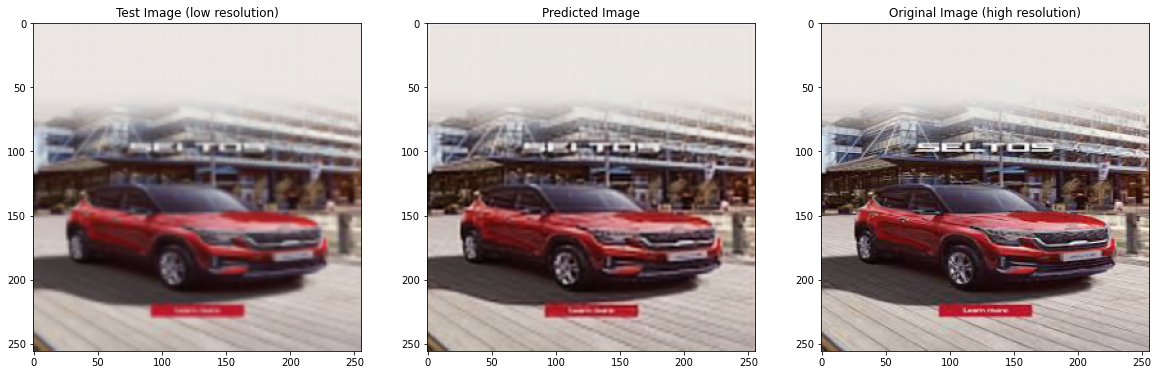

In [15]:
plot_image(images_l, images_h, decodificado, 1)

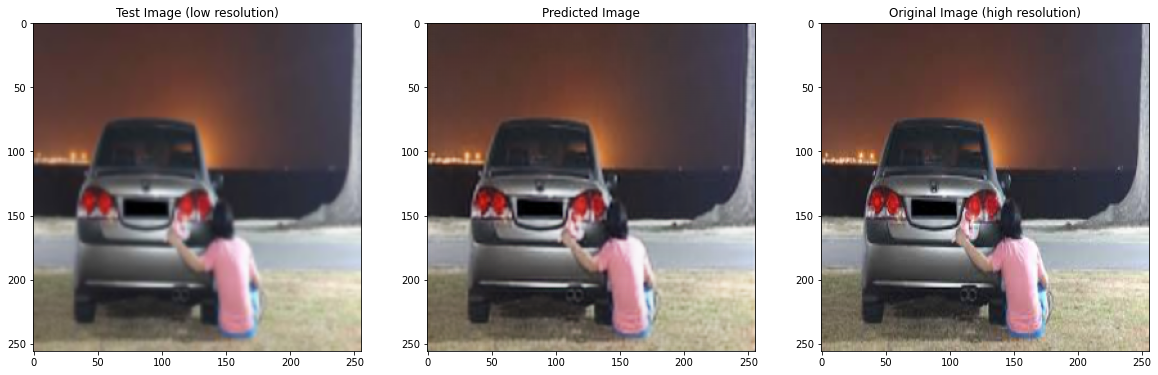

In [16]:
plot_image(images_l, images_h, decodificado, 10)

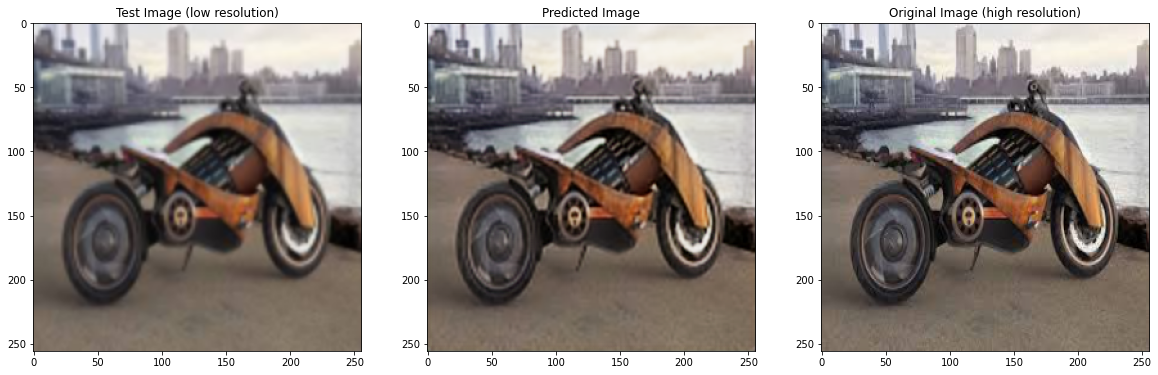

In [17]:
plot_image(images_l, images_h, decodificado, 15)

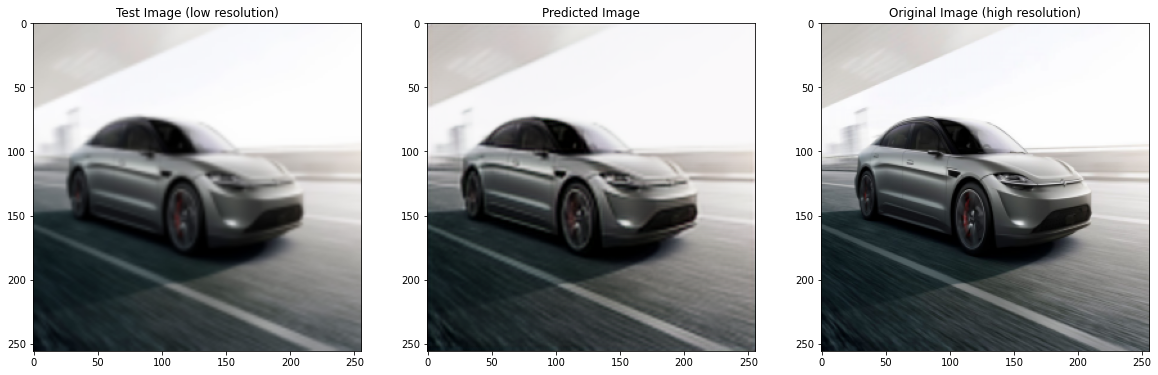

In [18]:
plot_image(images_l, images_h, decodificado, 30)